# AP3 - Movement Interpretation

Vorgehen zum Trainieren eines Modells:
1. Alle XLSX-Files aus einem Ordner einlesen. Dabei gibt der Ordner vor, ob es sich um BonaFide oder eine PA-Variante handelt.
2. Für jedes Files
2.1. File als DF einlesen
2.2. Hand-Nose Feature berechnen und in extra df speichern. Label wird auf Basis des Ordners vergeben
3. Man hat nun ein DF mit 2 Spalten: [[FeatureFrame1, FeatureFrame2,...][Label]]
4. sktime timeseries classification nutzen um zu klassifizieren

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Utils import parsXlsxToDf
from FeatureExtraction import euclideanDistance3dCalc, angleThreePoints3dCalc
from sktime.datasets import load_arrow_head
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sklearn.model_selection import train_test_split
from sktime.datatypes import convert
import sktime.datatypes
from sklearn.metrics import accuracy_score
from sktime.classification.base import BaseClassifier
import cv2
import mediapipe as mp

# SKTime Implementation - Univariate Time Series Classification

In [1]:
from Utils import getAllXlsx
import pandas as pd
from Utils import parsXlsxToDf
from FeatureExtraction import euclideanDistance3dCalc, angleThreePoints3dCalc

In [2]:
list_xlsx_bonaFide = getAllXlsx(input_directory='4_input_classification', select='BonaFide')
list_xlsx_PAD_Mask = getAllXlsx(input_directory='4_input_classification', select='PAD_Mask')
#list_xlsx_PAD_TShirt = getAllXlsx(input_directory='4_input_classification', select='PAD_T-Shirt')

df_bonaFide = pd.DataFrame(columns=['label', 'hand_nose'])
df_PAD = pd.DataFrame(columns=['label', 'hand_nose'])
file_nr = 0
for file in list_xlsx_bonaFide:
    file_nr += 1
    df_xlsx = parsXlsxToDf(file)
    dist_left_nose = euclideanDistance3dCalc(lm1='LEFT_WRIST', lm2='NOSE', df_in=df_xlsx, onlyDistSeriesReturn=True)
    df_bonaFide.loc[len(df_bonaFide)] = [0, dist_left_nose.tolist()]

for file in list_xlsx_PAD_Mask:
    df_xlsx = parsXlsxToDf(file)
    dist_left_nose = euclideanDistance3dCalc(lm1='LEFT_WRIST', lm2='NOSE', df_in=df_xlsx, onlyDistSeriesReturn=True)
    df_PAD.loc[len(df_PAD)] = [1, dist_left_nose.tolist()]

df_merged = [df_bonaFide, df_PAD]
df_merged = pd.concat(df_merged, ignore_index=True)

In [3]:
df_merged

,label,hand_nose
0,0,"[755.5999335611326, 2457.3627023130075, 778.07..."
1,0,"[894.6365943256135, 2629.9068896361073, 2586.5..."
2,0,"[956.5557464749445, 2579.3210465848583, 2540.1..."
3,0,"[1545.9189587972264, 2762.7972678542255, 2740...."
4,0,"[2358.9153597992326, 682.9523106001287, 641.14..."
...,...,...
93,1,"[2046.4069039003812, 2457.2290366294746, 2487...."
94,1,"[1010.2851442170897, 2794.6603648878695, 2765...."
95,1,"[2743.085412954469, 2910.7700942778074, 2873.0..."
96,1,"[839.8276553302215, 2665.137383574172, 2625.65..."


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.kernel_based import RocketClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import time
from sktime.classification.interval_based import DrCIF
from sktime.transformations.panel.compose import ColumnConcatenator

start = time.time()
# Split the data into features (X) and labels (y)
X = df_merged['hand_nose']
y = df_merged['label']
# Find the maximum length of the time series
max_length = max(len(seq) for seq in X)

# Pad the time series with zeros to the maximum length
X_padded = np.array([np.pad(seq, (0, max_length - len(seq)), 'constant') for seq in X])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Create a pipeline with classifier
# RocketClassifier() is a fast kernel based classifier
pipeline = Pipeline([
    ('classifier', RocketClassifier())
])
# TimeSeriesForestClassifier() is a slow interval based classifier
# pipeline = Pipeline([
#     ('classifier', TimeSeriesForestClassifier())
# ])

# Fit the pipeline
pipeline.fit(X_train, y_train)
end = time.time()
print("Time:", end - start)

Time: 12.706980228424072


In [4]:
# Make predictions on the test data
start = time.time()
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = pipeline.score(X_test, y_test)
print("Accuracy:", accuracy)
end = time.time()
print("Time:", end - start)

Accuracy: 1.0
Time: 6.2501060962677


In [5]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         9

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



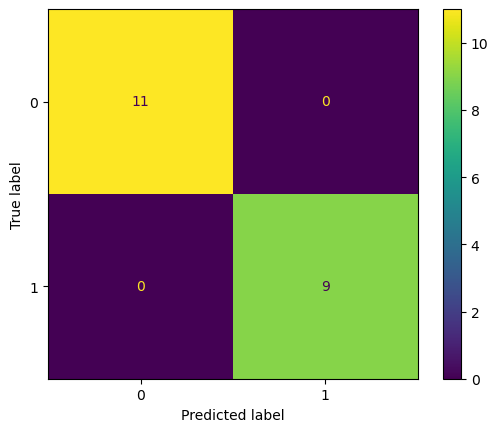

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

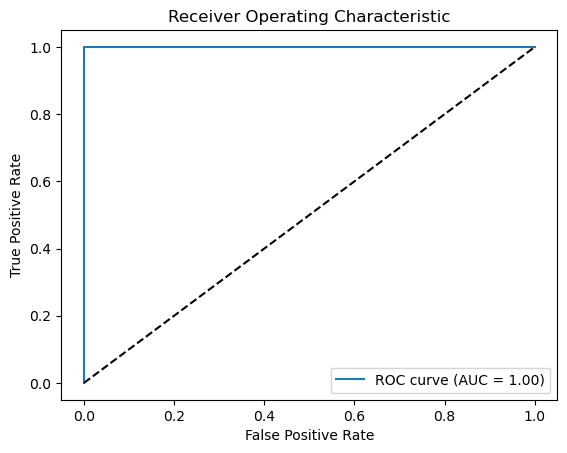

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute the predicted probabilities
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Compute the false positive rate, true positive rate, and threshold
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# SKTime Implementation - Multivariate Time Series Classification

In [6]:
from Utils import getAllXlsx
import pandas as pd
from Utils import parsXlsxToDf
from FeatureExtraction import euclideanDistance3dCalc, angleThreePoints3dCalc

In [7]:
list_xlsx_bonaFide = getAllXlsx(input_directory='4_input_classification', select='BonaFide')
list_xlsx_PAD_Mask = getAllXlsx(input_directory='4_input_classification', select='PAD_Mask')
list_xlsx_PAD_TShirt = getAllXlsx(input_directory='4_input_classification', select='PAD_T-Shirt')

df_bonaFide = pd.DataFrame(columns=['label', 'hand_nose', 'hand_hand'])
df_PAD = pd.DataFrame(columns=['label', 'hand_nose', 'hand_hand'])
file_nr = 0
for file in list_xlsx_bonaFide:
    file_nr += 1
    df_xlsx = parsXlsxToDf(file)
    dist_left_nose = euclideanDistance3dCalc(lm1='LEFT_WRIST', lm2='NOSE', df_in=df_xlsx, onlyDistSeriesReturn=True)
    dist_both_hands = euclideanDistance3dCalc(lm1='LEFT_WRIST', lm2='RIGHT_WRIST', df_in=df_xlsx, onlyDistSeriesReturn=True)
    df_bonaFide.loc[len(df_bonaFide)] = [0, dist_left_nose.tolist(), dist_both_hands.tolist()]

for file in list_xlsx_PAD_Mask:
    df_xlsx = parsXlsxToDf(file)
    dist_left_nose = euclideanDistance3dCalc(lm1='LEFT_WRIST', lm2='NOSE', df_in=df_xlsx, onlyDistSeriesReturn=True)
    dist_both_hands = euclideanDistance3dCalc(lm1='LEFT_WRIST', lm2='RIGHT_WRIST', df_in=df_xlsx, onlyDistSeriesReturn=True)
    df_PAD.loc[len(df_PAD)] = [1, dist_left_nose.tolist(), dist_both_hands.tolist()]

for file in list_xlsx_PAD_TShirt:
    df_xlsx = parsXlsxToDf(file)
    dist_left_nose = euclideanDistance3dCalc(lm1='LEFT_WRIST', lm2='NOSE', df_in=df_xlsx, onlyDistSeriesReturn=True)
    dist_both_hands = euclideanDistance3dCalc(lm1='LEFT_WRIST', lm2='RIGHT_WRIST', df_in=df_xlsx, onlyDistSeriesReturn=True)
    df_PAD.loc[len(df_PAD)] = [2, dist_left_nose.tolist(), dist_both_hands.tolist()]

df_merged = [df_bonaFide, df_PAD]
df_merged = pd.concat(df_merged, ignore_index=True)

Approach to handle multivariate time series data:
1. Concatenate the time series data into a single feature space
2. Use a transformation to convert the data into a univariate time series
3. Use a classifier that can handle univariate time series data

In [8]:
df_merged

,label,hand_nose,hand_hand
0,0,"[755.5999335611326, 2457.3627023130075, 778.07...","[462.6495610669502, 2330.4458984163216, 448.99..."
1,0,"[894.6365943256135, 2629.9068896361073, 2586.5...","[2522.637602107679, 2522.637602107679, 2522.63..."
2,0,"[956.5557464749445, 2579.3210465848583, 2540.1...","[2602.8482524209426, 2294.0306707538857, 2263...."
3,0,"[1545.9189587972264, 2762.7972678542255, 2740....","[3250.3945993420384, 3250.3945993420384, 2346...."
4,0,"[2358.9153597992326, 682.9523106001287, 641.14...","[4293.239651307972, 295.76802795514226, 281.64..."
...,...,...,...
142,2,"[552.3527631037892, 2566.6966088970507, 2551.0...","[299.79272609676906, 299.79272609676906, 2314...."
143,2,"[1678.9648670142676, 2575.876100157286, 2545.7...","[412.47930627135077, 412.47930627135077, 2297...."
144,2,"[730.2535762567915, 2643.5399331784574, 494.44...","[1769.844801409424, 2372.619222703574, 214.650..."
145,2,"[503.6051005817442, 539.1474748084486, 513.866...","[1603.240511899659, 1461.991084204037, 260.310..."


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sktime.classification.interval_based import DrCIF
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
import time

start = time.time()
# Split the data into features (X) and labels (y)
X = df_merged.drop('label', axis=1)
y = df_merged['label'].values

# Find the maximum length for each column in X
max_lengths = [max(len(seq) for seq in X[col]) for col in X.columns]

# Pad the time series with zeros to the maximum length for each column
X_padded = np.array([
    [np.pad(seq, (0, max_len - len(seq)), 'constant') for seq in series]
    for series, max_len in zip(X.values.T, max_lengths)
])
# Transpose X_padded to match the shape of y
X_padded = X_padded.transpose(1, 2, 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Create a pipeline with TimeSeriesForestClassifier
pipeline = Pipeline([
    ('concatenator', ColumnConcatenator()),  # Concatenate the multivariate time series
    ('classifier', TimeSeriesForestClassifier())  # Use the ROCKET classifier
])

# # Create a pipeline with RocketClassifier
# pipeline = Pipeline([
#     ('concatenator', ColumnConcatenator()),  # Concatenate the multivariate time series
#     ('classifier', RocketClassifier())  # Use the ROCKET classifier
# ])

# Fit the pipeline
pipeline.fit(X_train, y_train)
end = time.time()
print("Time:", end - start)

Time: 1.3658366203308105


In [10]:
start = time.time()
# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = pipeline.score(X_test, y_test)
print("Accuracy:", accuracy)
end = time.time()
print("Time:", end - start)

Accuracy: 1.0
Time: 0.9133453369140625


In [11]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         9

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



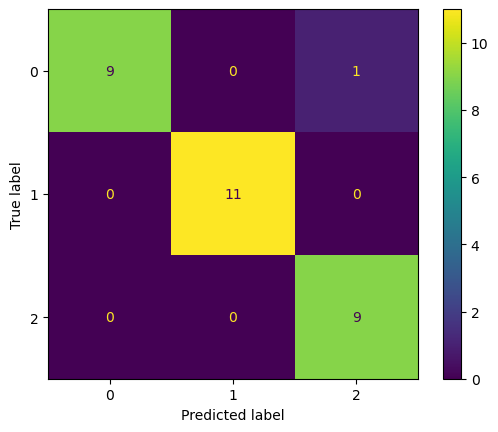

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

# KERAS LSTM-Netowrk (Just tested, not working)

In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Split the data into features (X) and labels (y)
X = df_merged['data'].tolist()
y = df_merged['label']

# Convert labels to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Normalize the training and testing data
scaler = MinMaxScaler()
X_train_normalized = [scaler.fit_transform(seq.reshape(-1, 1)) for seq in X_train]
X_test_normalized = [scaler.transform(seq.reshape(-1, 1)) for seq in X_test]

# Find the maximum sequence length
max_length = max(len(seq) for seq in X_train + X_test)

# Pad sequences to the maximum length
X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post', dtype='float32')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post', dtype='float32')

# Convert labels to categorical format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the RNN model
model = Sequential()
model.add(LSTM(64, input_shape=(max_length, 1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/10
3/3 [==============================] - 3s 426ms/step - loss: 0.6936 - accuracy: 0.4831 - val_loss: 0.7119 - val_accuracy: 0.4000
Epoch 2/10
3/3 [==============================] - 1s 174ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.7109 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 1s 173ms/step - loss: 0.6931 - accuracy: 0.4494 - val_loss: 0.7087 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 0s 168ms/step - loss: 0.6929 - accuracy: 0.5056 - val_loss: 0.7049 - val_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 0s 172ms/step - loss: 0.6927 - accuracy: 0.5056 - val_loss: 0.6991 - val_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 0s 170ms/step - loss: 0.6924 - accuracy: 0.5056 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 0s 165ms/step - loss: 0.6917 - accuracy: 0.5056 - val_loss: 0.6757 - val_accuracy: 0.5000
Epoch 8/10
3/3 [====